# **ATP Match Data Exploration**

Our goal here is to explore the match-level ATP data from [Jeff Sackmann](https://github.com/JeffSackmann/tennis_atp). We won't be doing any cleaning, manipulation, or extended analysis. We just are getting a handle on what the data contain. 

First we mount my google drive where I've saved the data we'll be using. Note that I've limited the data that I downloaded to 1991-2019 ATP tour-level main draw singles match-level data. There is some data for 2020 but the season has been interrupted so it makes things simpler to exclude this. There is also data available before 1991 but the match statistics are more sparsely populated.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

We then import the packages we'll need. 

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter 
import os
import glob
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We'll start by reading in the csv files and then appending them together. 

We also create a `year` field from the `tourney_id` field to keep track of the different yearly datasets.

In [41]:
os.chdir("/content/drive/My Drive/ATP Tennis/Data/")
filenames = [i for i in glob.glob('*.{}'.format('csv')) if "atp_matches" in i]
atp_matches = pd.concat([pd.read_csv(f) for f in filenames ])

In [42]:
atp_matches["year"] = [int(i[0:4]) for i in atp_matches["tourney_id"].values]

Taking a peak at the data, we see that there are lots of features to help us identify the tournament, the round in the tournament, the result, attributes about the players, and a variety of statistics from the match like duration, number of aces, first serves made, first serve points won, break points faced and saved, etc.  

In [44]:
atp_matches.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
0,2015-339,Brisbane,Hard,28,A,20150104,1,105357,NaN,WC,John Millman,R,183.0,AUS,25.560575,105733,NaN,Q,Rhyne Williams,R,NaN,USA,23.791923,6-3 6-1,3,R32,65.0,6.0,2.0,44.0,24.0,19.0,14.0,8.0,1.0,1.0,3.0,4.0,50.0,31.0,20.0,5.0,8.0,1.0,5.0,153.0,328.0,220.0,221.0,2015
1,2015-339,Brisbane,Hard,28,A,20150104,2,103813,NaN,NaN,Jarkko Nieminen,L,185.0,FIN,33.453799,106045,NaN,Q,Denis Kudla,R,180.0,USA,22.384668,4-6 6-1 6-4,3,R32,104.0,4.0,0.0,92.0,59.0,39.0,17.0,14.0,4.0,7.0,6.0,1.0,83.0,50.0,26.0,19.0,13.0,3.0,8.0,73.0,689.0,123.0,440.0,2015
2,2015-339,Brisbane,Hard,28,A,20150104,3,105902,NaN,WC,James Duckworth,R,183.0,AUS,22.956879,104468,6,NaN,Gilles Simon,R,183.0,FRA,30.023272,6-2 6-2,3,R32,68.0,4.0,0.0,45.0,27.0,20.0,11.0,8.0,2.0,3.0,2.0,1.0,56.0,37.0,22.0,5.0,8.0,10.0,15.0,125.0,430.0,21.0,1730.0,2015
3,2015-339,Brisbane,Hard,28,A,20150104,4,104871,NaN,NaN,Jeremy Chardy,R,188.0,FRA,27.895962,104979,NaN,NaN,Andrey Golubev,R,185.0,KAZ,27.457906,6-4 6-4,3,R32,69.0,7.0,1.0,53.0,39.0,31.0,11.0,10.0,0.0,0.0,9.0,2.0,57.0,38.0,30.0,8.0,10.0,1.0,3.0,31.0,1195.0,72.0,691.0,2015
4,2015-339,Brisbane,Hard,28,A,20150104,5,105373,NaN,NaN,Martin Klizan,L,190.0,SVK,25.486653,103781,NaN,NaN,Jurgen Melzer,L,183.0,AUT,33.623546,6-7(5) 7-6(6) 6-1,3,R32,144.0,9.0,4.0,130.0,79.0,55.0,27.0,16.0,6.0,8.0,4.0,4.0,95.0,62.0,40.0,19.0,15.0,4.0,8.0,34.0,1094.0,110.0,505.0,2015


We see that there are 95,887 matches and 50 variables in total, including `year` that we just added. Note that each row in the data represents a match. So there is information about both the match winner and loser on the same row. 

In [74]:
atp_matches.shape

(95887, 50)

**Explore High-Level Features**

Let's explore some of these fields. We start by looking at the unique values in `tourney_name`, `surface`, `draw_size`, `tourney_level`, `best_of`, `round`, and `year`. These give us a handle on whether we're seeing the high-level information we expect. 

Tournament names look like what we'd expect. It's interesting to note that the Davis Cup matches are broken out by the round and countries matched up in the round. So these matches take up most of the unique values. I only show the count to keep things simple, where Davis Cup only counts once. But we see there are  Note that we don't see any missing values but we do see some names that might need to be cleaned, if we decide this is a useful field to use. 

In [122]:
print("Number of Tournaments: ", \
      len([i for i in Counter(atp_matches[atp_matches["tourney_level"] != "D"]["tourney_name"])]) + 1)

Number of Tournaments:  191


Surface looks like what we want. Note how many more hard court and clay matches there are than grass court matches. Also it's interesting to see 'Carpet' as a category. The use of this surface ended in 2009. So we might want to remove it from our data.  We also see some missing values. 

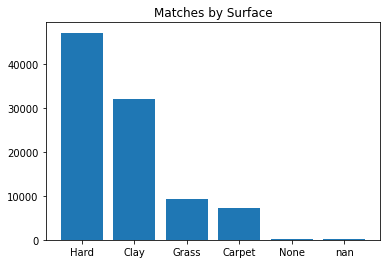

In [123]:
x = Counter(atp_matches["surface"])
plt.bar([str(i) for i in x.keys()], x.values())
plt.title("Matches by Surface")
plt.show()

Draw sizes are roughly what we expect. Note that all the matches from tournaments with draw size of 4 are Davis Cup. We might consider dropping Davis Cup from analyses, but we'll have to think about this some more. Olympics are another tournament type where country is involved and thus we might want to think harder about whether these tournaments are different from others in a meaningful way for our purposes. 

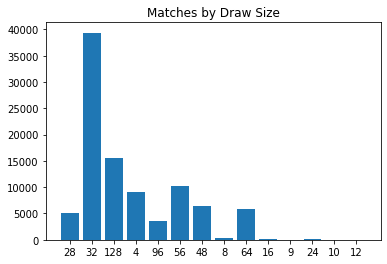

In [124]:
x = Counter(atp_matches["draw_size"])
plt.bar([str(i) for i in x.keys()], x.values())
plt.title("Matches by Draw Size")
plt.show()

In [101]:
Counter(atp_matches["draw_size"])

Counter({4: 9027,
         8: 376,
         9: 30,
         10: 15,
         12: 11,
         16: 131,
         24: 86,
         28: 5157,
         32: 39364,
         48: 6437,
         56: 10221,
         64: 5898,
         96: 3515,
         128: 15619})

In [59]:
Counter(atp_matches[atp_matches["tourney_level"] == "D"]["draw_size"])

Counter({4: 9027})

Tournament level is a coded variable. The data dictionary indicates that 

*   'A' = other tour-level events
*   'D' = Davis Cup
*   'F' = Tour finals and other season-ending events
*   'G' = Grand Slams
*   'M' = Masters 1000s

This will be a convenient way to filter to tournaments that we're most interested in. (We've already made use of this above.)


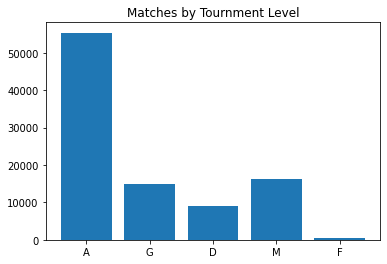

In [125]:
x = Counter(atp_matches["tourney_level"])
plt.bar([str(i) for i in x.keys()], x.values())
plt.title("Matches by Tournment Level")
plt.show()

In [151]:
Counter(atp_matches["tourney_level"])

Counter({'A': 55388, 'D': 9027, 'F': 451, 'G': 14859, 'M': 16162})

The `best_of` feature only takes values of 3 or 5, as we'd expect. Note that we see that all Grand Slams are best of 5 sets, but there are some other tournaments that are as well.

In [64]:
atp_matches.groupby(["best_of", "tourney_level"]).size()

best_of  tourney_level
3        A                55163
         D                 2914
         F                  435
         M                16068
5        A                  225
         D                 6113
         F                   16
         G                14859
         M                   94
dtype: int64

Next, `round` has the matches round in the tournament (finals, semis, round robin, round of 16, etc.). As we expect there are more early round matches but most round of 32 since there are more draw sizes of 32.

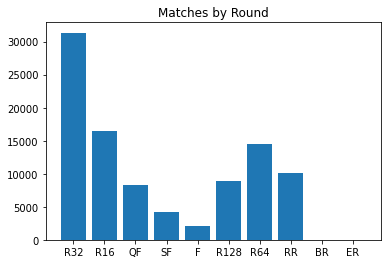

In [126]:
x = Counter(atp_matches["round"])
plt.bar([str(i) for i in x.keys()], x.values())
plt.title("Matches by Round")
plt.show()

Finally, `year` shows us that there are between 2,500 and 4,000 of tournaments each year. We see that the numbers have been falling over time, however. We see the dramatic drop in 2020 due to the partial year of data and the interrupted season.  

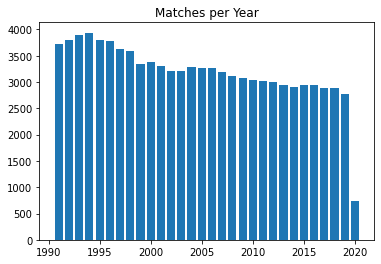

In [127]:
year = Counter(atp_matches["year"])
plt.bar(year.keys(), year.values())
plt.title("Matches per Year")
plt.show()

So we see pretty much what we expect and, notably, only `surface` has missing values and not that many. 



**Missing Values**

But let's be a bit more systematic about checking for missing values. We count the number of matches with missing values for each of the 50 fields in the data. We see some interesting patterns. 

We again see the 118 missing values for `surface`. 

But we also see very high numbers for `winner_seed`, `winner_entry`, `loser_seed`, and `loser_entry`. We know what the seeds are. The data dictionary tells us that the entry fields are things like 'WC' = wild card, 'Q' = qualifier, 'LL' = lucky loser, and 'PR' = protected ranking. So it makes some sense that these are not populated for most of the entries. Since we also have ATP rank (which is missing far less), we'll probably be ok without these. 

Player heights are also missing for several thousand matches. If we decide we need height later, we'll have to see how we might try to populate these. Depending on the pattern of these missing values there might be a chance to fill in the gaps. But we'll leave that for later. 

We see a very small number of missing ages and handedness indicators. These won't likely be a problem and we, again, might be able to repopulate these, if necessary. 

Below, we'll investigate some of the other fields with missing values more closely.

In [137]:
atp_matches.isnull().sum()

tourney_id                0
tourney_name              0
surface                 118
draw_size                 0
tourney_level             0
tourney_date              0
match_num                 0
winner_id                 0
winner_seed           57220
winner_entry          84583
winner_name               0
winner_hand              20
winner_ht              6584
winner_ioc                0
winner_age               93
loser_id                  0
loser_seed            74772
loser_entry           77145
loser_name                0
loser_hand               56
loser_ht              10225
loser_ioc                 0
loser_age               202
score                     2
best_of                   0
round                     0
minutes               12421
w_ace                  9791
w_df                   9791
w_svpt                 9791
w_1stIn                9791
w_1stWon               9791
w_2ndWon               9791
w_SvGms                9791
w_bpSaved              9791
w_bpFaced           

There are two matches without scores. These two matches are from 1997 and 2007 for the Kitzbuhel and Costa Do Sauipe tournaments, respectively.	We see that the later match is missing many fields. So there could be something going on there. We dont see any obvious indication of why there is no `score` but we do have information on who won and lost. So perhaps not all is lost, unless we want to analyze specific scores.  

In [138]:
atp_matches[atp_matches["score"].isnull()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
2325,1997-319,Kitzbuhel,Clay,48,A,19970721,6,102506,NaN,Q,Quino Munoz,R,178.0,ESP,22.543463,102473,NaN,Q,Thomas Schiessling,R,180.0,AUT,22.718686,NaN,5,R64,99.0,0.0,2.0,80.0,42.0,25.0,28.0,10.0,5.0,6.0,2.0,2.0,69.0,34.0,24.0,17.0,10.0,2.0,5.0,277.0,140.0,877.0,10.0,1997
2137,2007-533,Costa Do Sauipe,Clay,32,A,20070212,6,104160,NaN,NaN,Lukas Dlouhy,R,185.0,CZE,23.846680,104214,NaN,NaN,Igor Andreev,R,185.0,RUS,23.583847,NaN,5,R32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,369.0,147.0,305.0,2007


Next, we'll look into what appears to be a pattern of missing match statistics. There are 9,791 matches with missing values for all the detail performance stats (aces, first serves, break points, etc.). This is probably a systematic deficiency of some slice of the data.

We see that indeed the same 9,791 matches are missing all the detail performance stats. The read-me for the data states that "*There are some tour-level matches with missing stats. Some are missing because ATP doesn't have them. Others I've deleted because they didn't pass some sanity check (loser won 60% of points, or match time was under 20 minutes, etc). Also, Davis Cup matches are included in the tour-level files, but there are no stats for Davis Cup matches until the last few seasons.*" 

We do see that most of these are Davis Cup matches. So again, the Davis Cup data might not be a good thing to include. Given that the rest had some suspicious data, we'll probably want to drop these form our data for analysis. 

Note that these also account for all the missing surfaces, a sizeable number of the matches with missing heights/ages/handedness, one of the matches with missing score, and many of those without player ranks. 

In [141]:
missing_detail_stats = atp_matches[atp_matches["w_ace"].isnull()]
missing_detail_stats.isnull().sum()

tourney_id               0
tourney_name             0
surface                118
draw_size                0
tourney_level            0
tourney_date             0
match_num                0
winner_id                0
winner_seed           9164
winner_entry          9630
winner_name              0
winner_hand             12
winner_ht             2655
winner_ioc               0
winner_age              89
loser_id                 0
loser_seed            9372
loser_entry           9542
loser_name               0
loser_hand              26
loser_ht              4132
loser_ioc                0
loser_age              152
score                    1
best_of                  0
round                    0
minutes               9770
w_ace                 9791
w_df                  9791
w_svpt                9791
w_1stIn               9791
w_1stWon              9791
w_2ndWon              9791
w_SvGms               9791
w_bpSaved             9791
w_bpFaced             9791
l_ace                 9791
l

In [144]:
Counter(missing_detail_stats["tourney_level"])

Counter({'A': 1113, 'D': 8155, 'F': 14, 'G': 316, 'M': 193})

When we look at the missing observations, after removing these 9,791 matches and all the more recent Davis Cup matches, we see that many of our missing data issues are improved. 

In [150]:
nonmissing_detail_stats = atp_matches[atp_matches["w_ace"].notnull()]
nonmissing_detail_stats = nonmissing_detail_stats[nonmissing_detail_stats["tourney_level"] != "D"]
nonmissing_detail_stats.isnull().sum()

tourney_id                0
tourney_name              0
surface                   0
draw_size                 0
tourney_level             0
tourney_date              0
match_num                 0
winner_id                 0
winner_seed           47184
winner_entry          74081
winner_name               0
winner_hand               0
winner_ht              3441
winner_ioc                0
winner_age                2
loser_id                  0
loser_seed            64528
loser_entry           66731
loser_name                0
loser_hand                0
loser_ht               5463
loser_ioc                 0
loser_age                40
score                     1
best_of                   0
round                     0
minutes                2637
w_ace                     0
w_df                      0
w_svpt                    0
w_1stIn                   0
w_1stWon                  0
w_2ndWon                  0
w_SvGms                   0
w_bpSaved                 0
w_bpFaced           

We still need to look into the missing values in `minutes`, the rank fields, and the rank point fields. 

`minutes` tends to be missing primarily in 2015 and in years before 2000. There doesn't appear to be a pattern based on tournament. The data dictionary mentions that this field is only popoulated "where available." So, while we'd like to have this information, there might not be too much we can do on this front other than exclude these matches from analyses that need match duration. 

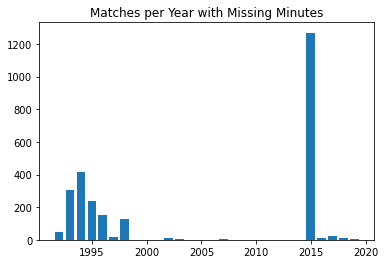

In [160]:
Counter(nonmissing_detail_stats[nonmissing_detail_stats["minutes"].isnull()]["tourney_name"])
year = Counter(nonmissing_detail_stats[nonmissing_detail_stats["minutes"].isnull()]["year"])
plt.bar(year.keys(), year.values())
plt.title("Matches per Year with Missing Minutes")
plt.show()

The rank fields don't appear to have too much of a pattern by year. I also checked a series of other fields to no avail. Since there are relatively few, we may exclude these from analysis. 

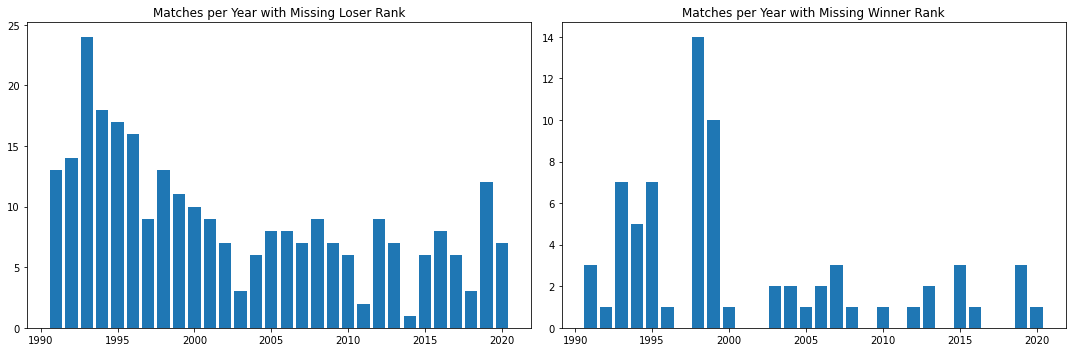

In [424]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
year = Counter(nonmissing_detail_stats[nonmissing_detail_stats["loser_rank"].isnull()]["year"])
plt.bar(year.keys(), year.values())
plt.title("Matches per Year with Missing Loser Rank")

plt.subplot(1, 2, 2)
year = Counter(nonmissing_detail_stats[nonmissing_detail_stats["winner_rank"].isnull()]["year"])
plt.bar(year.keys(), year.values())
plt.title("Matches per Year with Missing Winner Rank")

plt.tight_layout()
plt.show()

The rank points fields tend to be missing in earlier years of data. Here the data dictionary again says that the rank points are populated only "when available." It would be nice to have these since there are over 1,000 matches that are missing these. But there might not be too much we can do on that. 

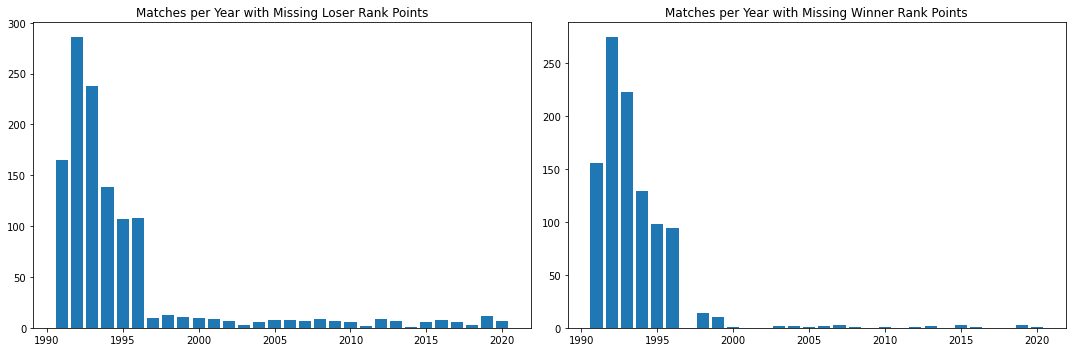

In [423]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
year = Counter(nonmissing_detail_stats[nonmissing_detail_stats["loser_rank_points"].isnull()]["year"])
plt.bar(year.keys(), year.values())
plt.title("Matches per Year with Missing Loser Rank Points")

plt.subplot(1, 2, 2)
year = Counter(nonmissing_detail_stats[nonmissing_detail_stats["winner_rank_points"].isnull()]["year"])
plt.bar(year.keys(), year.values())
plt.title("Matches per Year with Missing Winner Rank Points")

plt.tight_layout()
plt.show()

This is all we'll do here so far as exploring missing values goes. 

**Explore Player Information**

We'll move forward using only the data removing the 9,791 matches without detail stats and Davis Cup matches. Let's look at some of the player information we have. 

We'll start by looking at player names and IDs to ensure these look reasonable and have a one-to-one mapping. We see that there are a total of 2,029 unique player ID-name pairs. None of the names look too concerning in terms of spelling and we do see a one-to-one mapping from name to ID. So we should be able to trust these to help us track player identities.



In [185]:
losers = nonmissing_detail_stats[["loser_id","loser_name"]]
losers = losers.rename(columns={"loser_id": "id", "loser_name": "name"})
winners = nonmissing_detail_stats[["winner_id","winner_name"]]
winners = losers.rename(columns={"winner_id": "id", "winner_name": "name"})
players = pd.concat([losers,winners])
players = players.groupby(['id','name']).size().reset_index().rename(columns={0:'count'})

In [180]:
id_check = players.groupby(['id']).size().reset_index().rename(columns={0:'count'})
print("Number of Player IDs Associated with More than One Name: ",len(id_check[id_check['count']>1]))

Number of Player IDs Associated with More than One Name:  0


In [181]:
name_check = players.groupby(['name']).size().reset_index().rename(columns={0:'count'})
print("Number of Player Names Associated with More than One ID: ",len(name_check[name_check['count']>1]))

Number of Player Names Associated with More than One ID:  0


Out of curiosity, I check which players appear for the highest number of matches. We see that Feliciano Lopez has played the most matches at 872. This makes sense when you consider that his first win was at age 19 and his latest win was at age 38. There are a handful of other players with similarly impressive lengths of careers. But most players play many fewer matched and have much shorter durations between their first and last win. Despite his success, Roger Federer is no where near the top in terms of matches played. 



In [205]:
players.sort_values("count",ascending=False)[0:5]

,id,name,count
1153,103852,Feliciano Lopez,872
1279,104269,Fernando Verdasco,826
566,102148,Fabrice Santoro,814
1202,104022,Mikhail Youzhny,804
1296,104312,Andreas Seppi,762


In [221]:
players.sort_values("count",ascending=False)[players.sort_values("count",ascending=False)["name"]=="Roger Federer"]

,id,name,count
1138,103819,Roger Federer,518


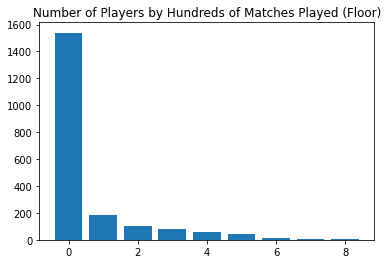

In [233]:
simple_count = np.floor(players["count"]/100)
x = Counter(simple_count)
plt.bar(x.keys(), x.values())
plt.title("Number of Players by Hundreds of Matches Played (Floor)")
plt.show()

In [236]:
def MinMaxAge(name):
  print(name,"Min Win Age: ",nonmissing_detail_stats[(nonmissing_detail_stats["winner_name"]==name)]["winner_age"].min())
  print(name,"Max Win Age: ",nonmissing_detail_stats[(nonmissing_detail_stats["winner_name"]==name)]["winner_age"].max())
  
MinMaxAge("Feliciano Lopez")

Feliciano Lopez Min Win Age:  19.3976728268
Feliciano Lopez Max Win Age:  38.3709787817


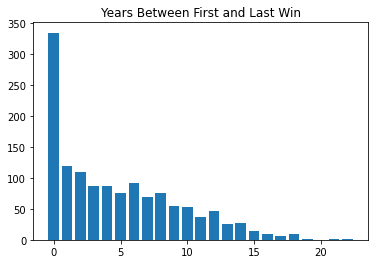

In [222]:
MinMaxAgesData = nonmissing_detail_stats.groupby(['winner_name'])['year'].agg(['min','max']).reset_index()
MinMaxAgesData["years_between_wins"] = np.round(MinMaxAgesData["max"] - MinMaxAgesData["min"])
x = Counter(MinMaxAgesData["years_between_wins"])
plt.bar(x.keys(), x.values())
plt.title("Years Between First and Last Win")
plt.show()

Before we get too side tracked, let's get back to exploring the player information. We have data on handedness, height, age, and country. 

As expected, we see many more righties than lefties. There are a few players with unknown handedness.



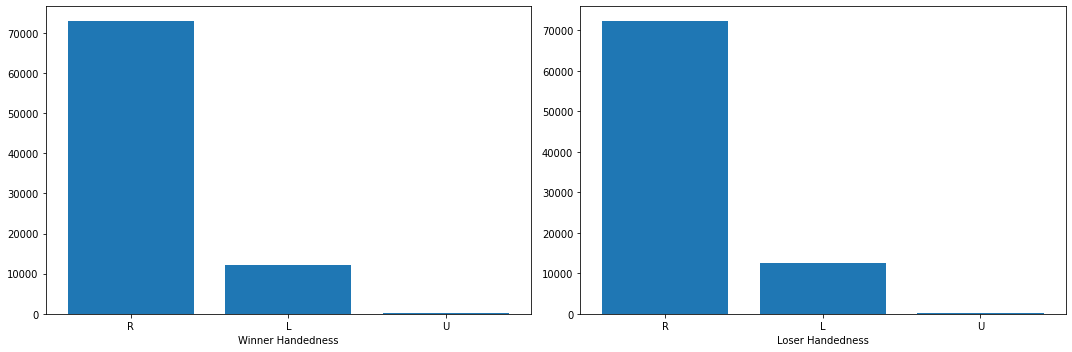

In [421]:
plt.figure(figsize=(15,5))
x = Counter(nonmissing_detail_stats["winner_hand"])
plt.subplot(1, 2, 1)
plt.bar([str(i) for i in x.keys()], x.values())
plt.xlabel("Winner Handedness")

x = Counter(nonmissing_detail_stats["loser_hand"])
plt.subplot(1, 2, 2)
plt.bar([str(i) for i in x.keys()], x.values())
plt.xlabel("Loser Handedness")

plt.tight_layout()
plt.show()

Heights and ages are roughly what we expect. There is an odd gap in the winner height distribution. Ages are skewed slightly younger.

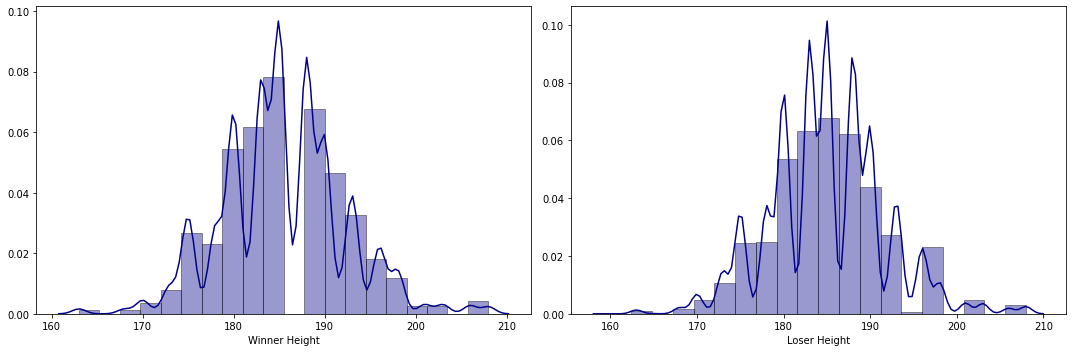

In [420]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.distplot(nonmissing_detail_stats["winner_ht"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Winner Height")

plt.subplot(1, 2, 2)
sns.distplot(nonmissing_detail_stats["loser_ht"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Loser Height")

plt.tight_layout()
plt.show()

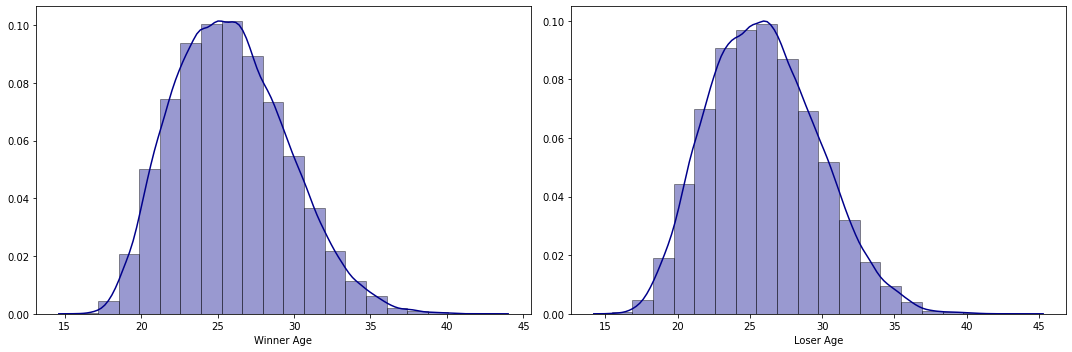

In [419]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.distplot(nonmissing_detail_stats["winner_age"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Winner Age")

plt.subplot(1, 2, 2)
sns.distplot(nonmissing_detail_stats["loser_age"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Loser Age")

plt.tight_layout()
plt.show()

Most matches are won and lost by Spanish and American players. Europe is the most represented continent.

In [273]:
nonmissing_detail_stats.groupby(['winner_ioc']).size().reset_index().rename(columns={0:'count'}).sort_values("count",ascending=False)[0:10]

,winner_ioc,count
27,ESP,10945
78,USA,10020
30,FRA,7511
33,GER,5428
1,ARG,4788
65,RUS,3806
3,AUS,3761
71,SWE,3684
21,CZE,3230
39,ITA,2787


In [272]:
nonmissing_detail_stats.groupby(['loser_ioc']).size().reset_index().rename(columns={0:'count'}).sort_values("count",ascending=False)[0:10]

,loser_ioc,count
28,ESP,9551
87,USA,9286
31,FRA,7743
34,GER,6092
1,ARG,4670
3,AUS,3795
44,ITA,3720
72,RUS,3471
22,CZE,3264
78,SWE,3243


**Explore Detail Statistics**

Next we'll look at the detailed match statistics. These include numbers of aces, double faults, serve points, first serves made, first-serve points won, second-serve points won, serve games, break points saved, and break points faced. We have these statistics for both the winner and loser of every match.  

We'll discuss all these here and then show the densities. Aces range between zero and ~100. The distributions are heavily skewed toward zero. Winners tend to have more aces, as we might expect. Double faults are also skewed toward zero and max out around 30. Losers tend to have slightly more. In terms of service, both winners and losers look pretty similar. Winners break their opponents more often, face fewer break points, and perform better on their own break points. From these simple density plots alone, we can see that break points appear to be an important metric for determining the winner. Anyone who plays or watches tennis will not be suprised. 

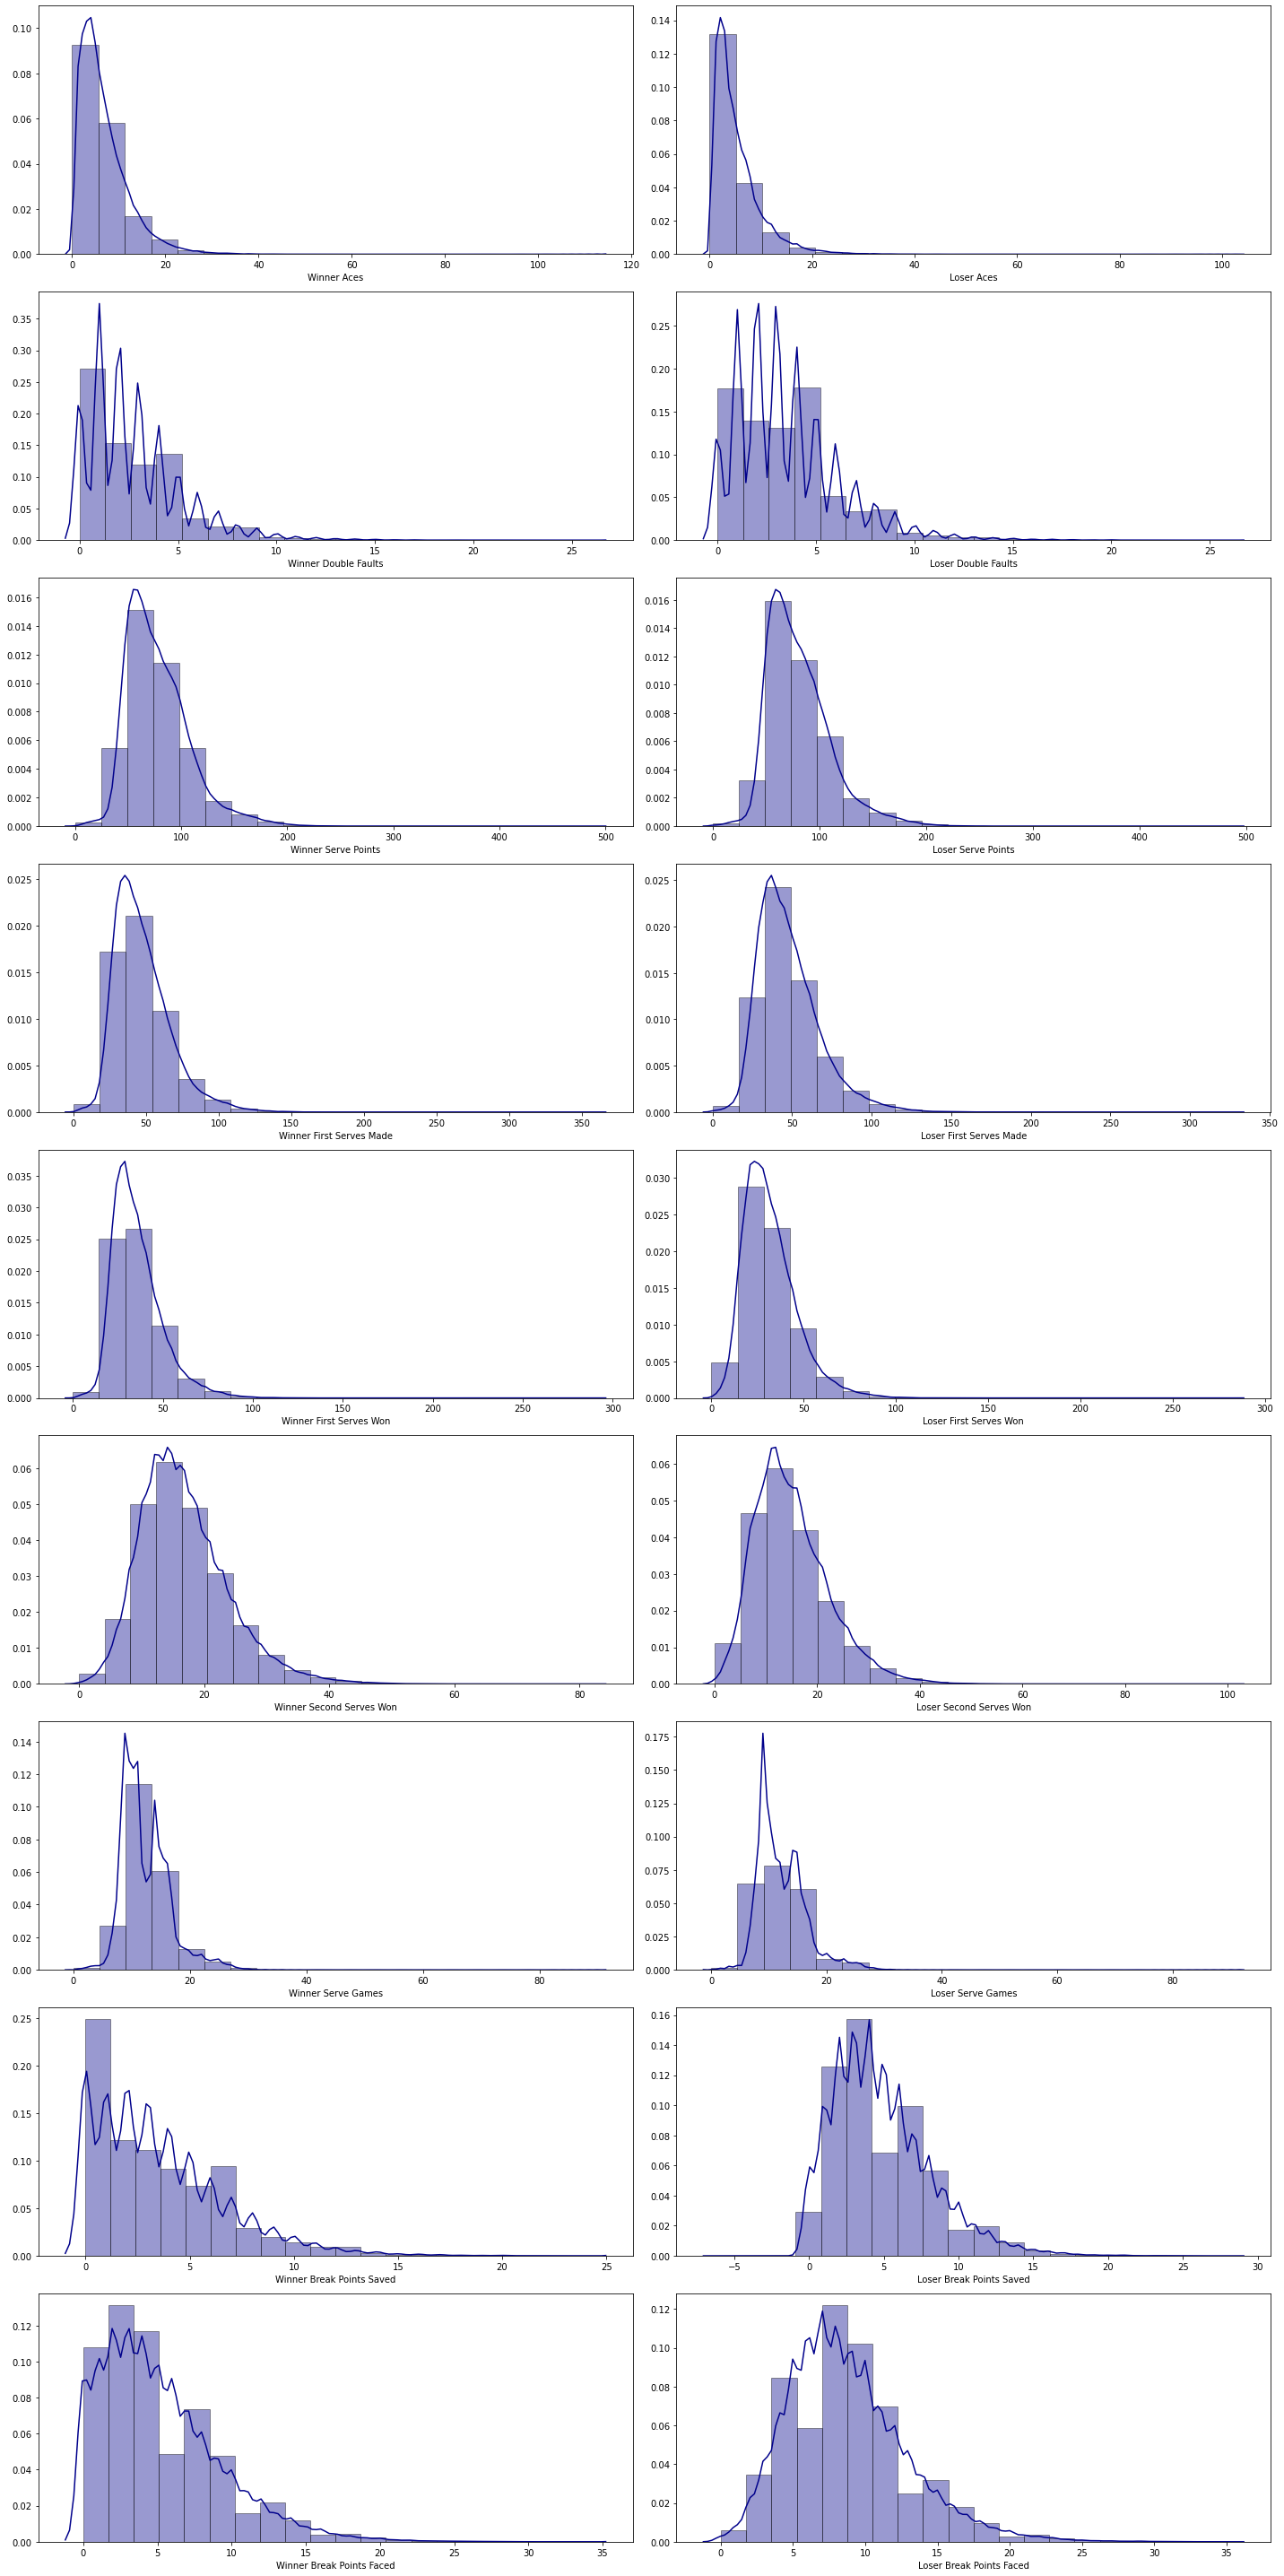

In [295]:
plt.figure(figsize=(20,40))

plt.subplot(9, 2, 1)
sns.distplot(nonmissing_detail_stats["w_ace"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Winner Aces")

plt.subplot(9, 2, 2)
sns.distplot(nonmissing_detail_stats["l_ace"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Loser Aces")

plt.subplot(9, 2, 3)
sns.distplot(nonmissing_detail_stats["w_df"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Winner Double Faults")

plt.subplot(9, 2, 4)
sns.distplot(nonmissing_detail_stats["l_df"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Loser Double Faults")

plt.subplot(9, 2, 5)
sns.distplot(nonmissing_detail_stats["w_svpt"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Winner Serve Points")

plt.subplot(9, 2, 6)
sns.distplot(nonmissing_detail_stats["l_svpt"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Loser Serve Points")

plt.subplot(9, 2, 7)
sns.distplot(nonmissing_detail_stats["w_1stIn"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Winner First Serves Made")

plt.subplot(9, 2, 8)
sns.distplot(nonmissing_detail_stats["l_1stIn"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Loser First Serves Made")

plt.subplot(9, 2, 9)
sns.distplot(nonmissing_detail_stats["w_1stWon"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Winner First Serves Won")

plt.subplot(9, 2, 10)
sns.distplot(nonmissing_detail_stats["l_1stWon"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Loser First Serves Won")

plt.subplot(9, 2, 11)
sns.distplot(nonmissing_detail_stats["w_2ndWon"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Winner Second Serves Won")

plt.subplot(9, 2, 12)
sns.distplot(nonmissing_detail_stats["l_2ndWon"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Loser Second Serves Won")

plt.subplot(9, 2, 13)
sns.distplot(nonmissing_detail_stats["w_SvGms"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Winner Serve Games")

plt.subplot(9, 2, 14)
sns.distplot(nonmissing_detail_stats["l_SvGms"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Loser Serve Games")

plt.subplot(9, 2, 15)
sns.distplot(nonmissing_detail_stats["w_bpSaved"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Winner Break Points Saved")

plt.subplot(9, 2, 16)
sns.distplot(nonmissing_detail_stats["l_bpSaved"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Loser Break Points Saved")

plt.subplot(9, 2, 17)
sns.distplot(nonmissing_detail_stats["w_bpFaced"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Winner Break Points Faced")

plt.subplot(9, 2, 18)
sns.distplot(nonmissing_detail_stats["l_bpFaced"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Loser Break Points Faced")

plt.tight_layout()
plt.show()

**Explore Score, Minutes, and Ranks**

Let's turn to exploring the score, minute, and rank information. 

To explore the score in games, we'll break it down by set and winner vs loser. We ignore tie break scores for now. But the winner of the tie break is reflected in the score in games. We see roughly the expected results. That is, most matches are played as best of 3 sets. Some are played as best of 5. We also see a small number of blank or non-sensical values. 


In [379]:
set_scores = nonmissing_detail_stats["score"].str.split(" ", expand = True) 

def get_set_scores(set_num):
  set_1 = set_scores[set_num-1]
  set_1 = set_1.str.split("-", expand = True) 
  set_1b = set_1[1].str.split("(", expand = True) 
  set1_winner = set_1[0]
  set1_loser = set_1b[0]
  set_1 = pd.concat([set1_winner, set1_loser], axis=1)
  set_1.columns=["winner_set_"+str(set_num)+"_score","loser_set_"+str(set_num)+"_score"]
  return set_1

set_1 = get_set_scores(1)
set_2 = get_set_scores(2)
set_3 = get_set_scores(3)
set_4 = get_set_scores(4)
set_5 = get_set_scores(5)

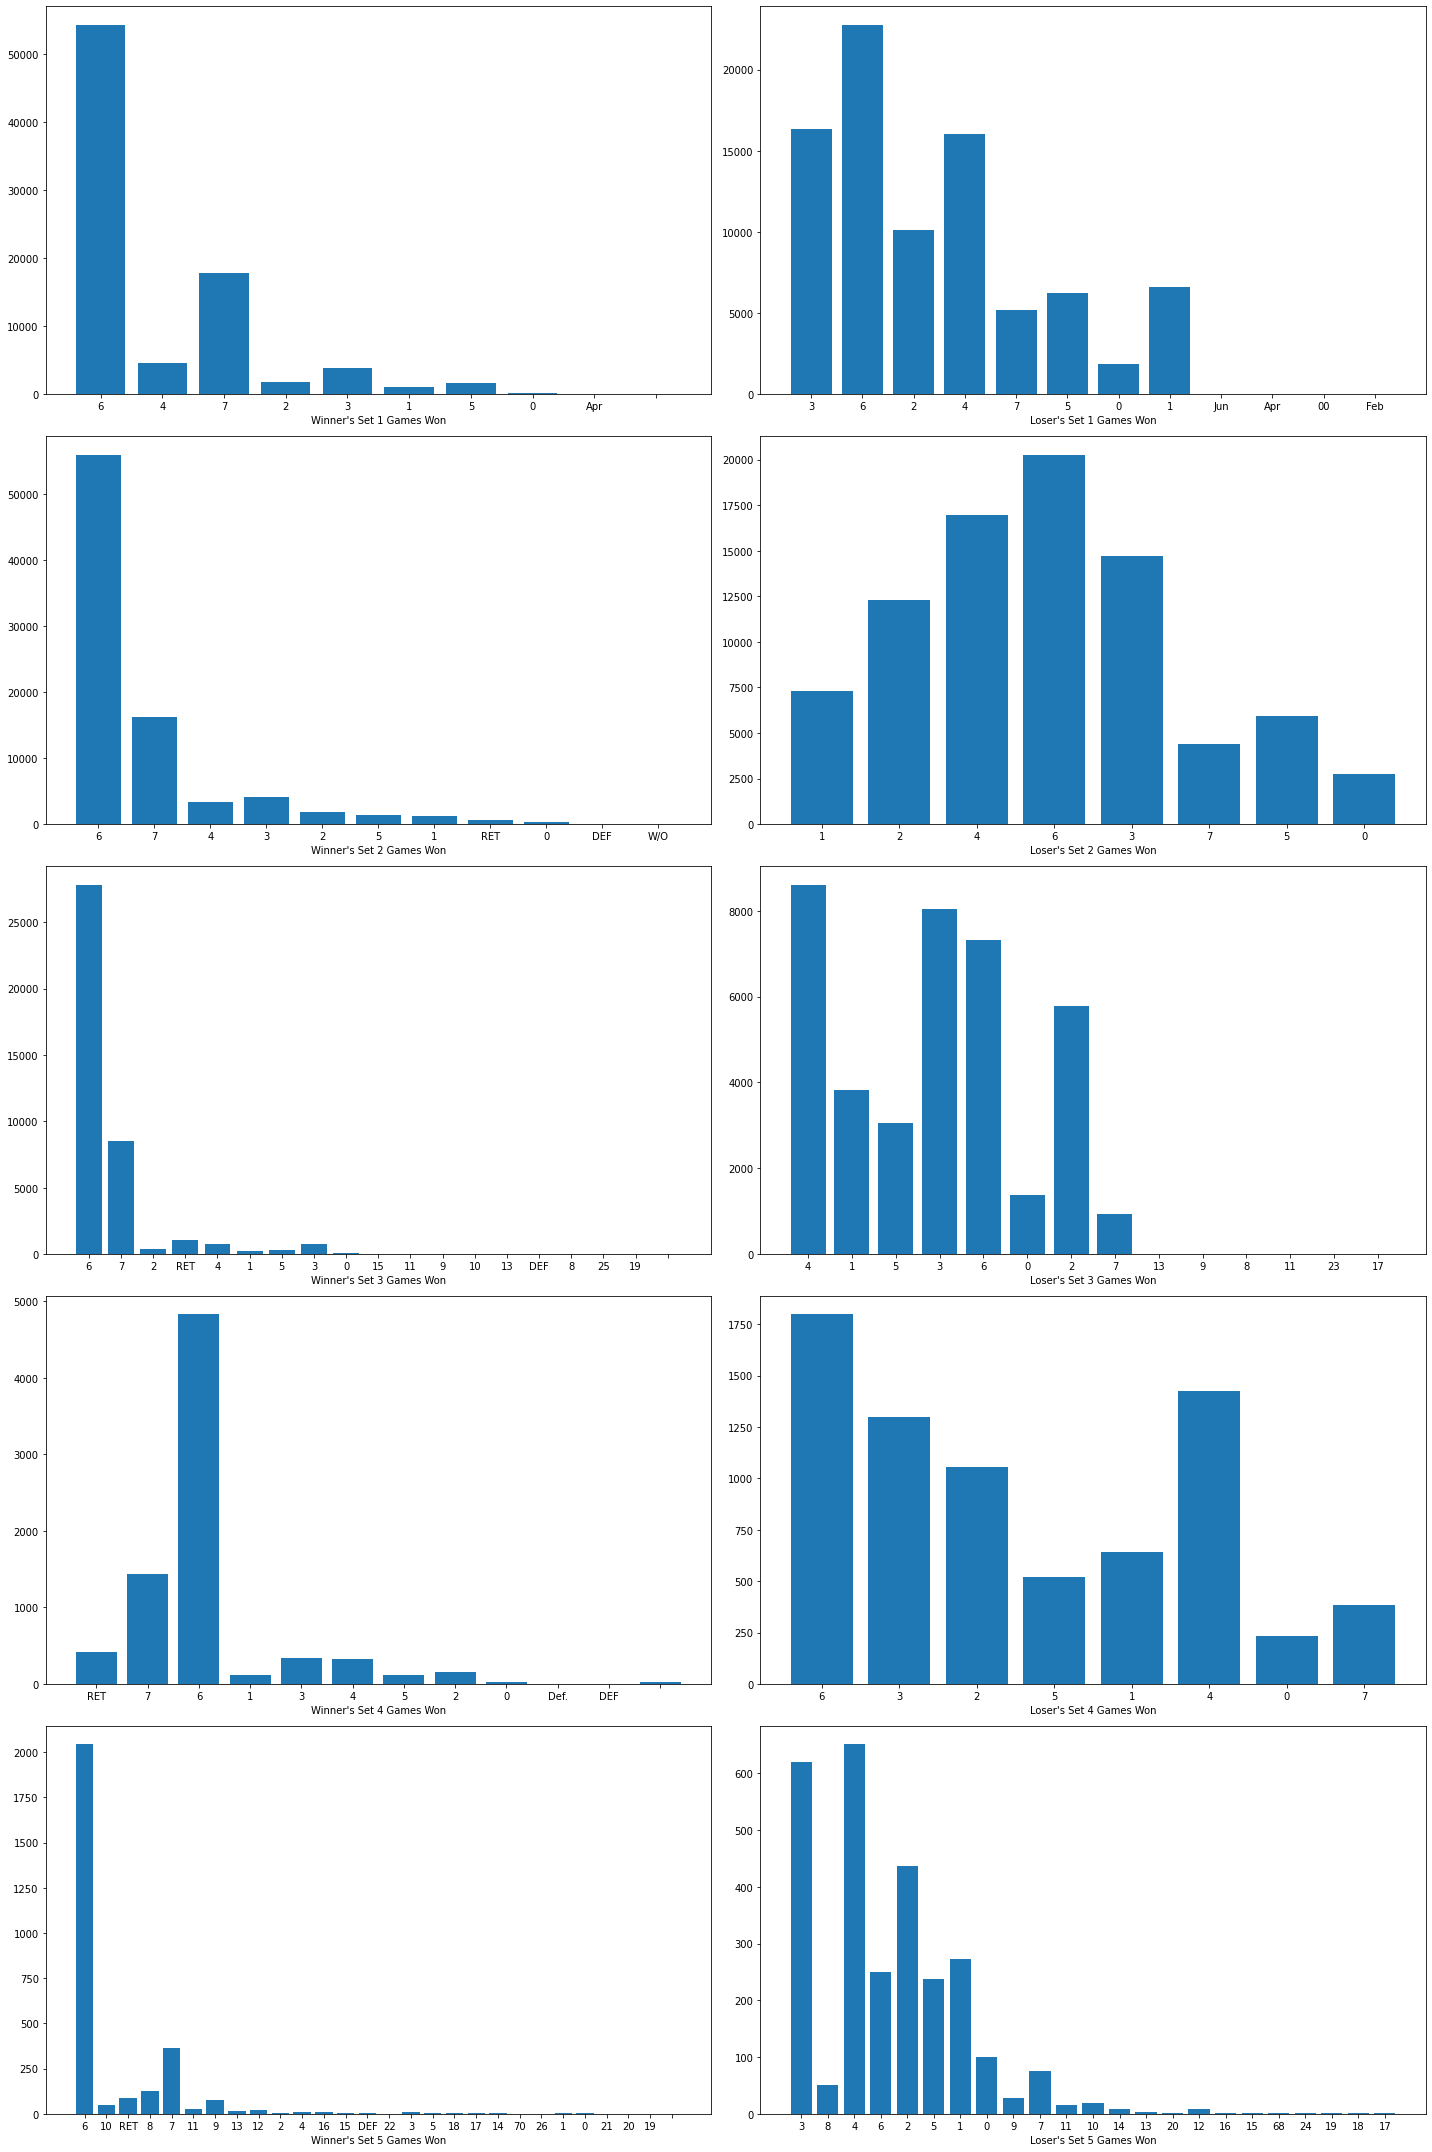

In [408]:
plt.figure(figsize=(20,30))

x = Counter(set_1["winner_set_1_score"][set_1["winner_set_1_score"].notnull()])
plt.subplot(5, 2, 1)
plt.bar([str(i) for i in x.keys()], x.values())
plt.xlabel("Winner's Set 1 Games Won")

x = Counter(set_1["loser_set_1_score"][set_1["loser_set_1_score"].notnull()])
plt.subplot(5, 2, 2)
plt.bar([str(i) for i in x.keys()], x.values())
plt.xlabel("Loser's Set 1 Games Won")

x = Counter(set_2["winner_set_2_score"][set_2["winner_set_2_score"].notnull()])
plt.subplot(5, 2, 3)
plt.bar([str(i) for i in x.keys()], x.values())
plt.xlabel("Winner's Set 2 Games Won")

x = Counter(set_2["loser_set_2_score"][set_2["loser_set_2_score"].notnull()])
plt.subplot(5, 2, 4)
plt.bar([str(i) for i in x.keys()], x.values())
plt.xlabel("Loser's Set 2 Games Won")

x = Counter(set_3["winner_set_3_score"][set_3["winner_set_3_score"].notnull()])
plt.subplot(5, 2, 5)
plt.bar([str(i) for i in x.keys()], x.values())
plt.xlabel("Winner's Set 3 Games Won")

x = Counter(set_3["loser_set_3_score"][set_3["loser_set_3_score"].notnull()])
plt.subplot(5, 2, 6)
plt.bar([str(i) for i in x.keys()], x.values())
plt.xlabel("Loser's Set 3 Games Won")

x = Counter(set_4["winner_set_4_score"][set_4["winner_set_4_score"].notnull()])
plt.subplot(5, 2, 7)
plt.bar([str(i) for i in x.keys()], x.values())
plt.xlabel("Winner's Set 4 Games Won")

x = Counter(set_4["loser_set_4_score"][set_4["loser_set_4_score"].notnull()])
plt.subplot(5, 2, 8)
plt.bar([str(i) for i in x.keys()], x.values())
plt.xlabel("Loser's Set 4 Games Won")

x = Counter(set_5["winner_set_5_score"][set_5["winner_set_5_score"].notnull()])
plt.subplot(5, 2, 9)
plt.bar([str(i) for i in x.keys()], x.values())
plt.xlabel("Winner's Set 5 Games Won")

x = Counter(set_5["loser_set_5_score"][set_5["loser_set_5_score"].notnull()])
plt.subplot(5, 2, 10)
plt.bar([str(i) for i in x.keys()], x.values())
plt.xlabel("Loser's Set 5 Games Won")

plt.tight_layout()
plt.show()

Looking at `minutes` we see that most matches are less than 3 hours and that there is a pretty long tail.

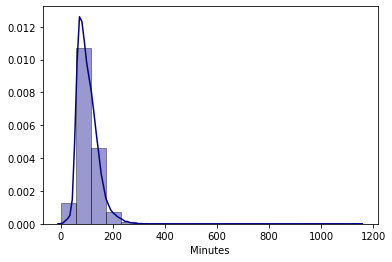

In [409]:
sns.distplot(nonmissing_detail_stats["minutes"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Minutes")
plt.show()

There isnt much suprising about the ranks or rank points. Though, as we saw above there are some missing values. 

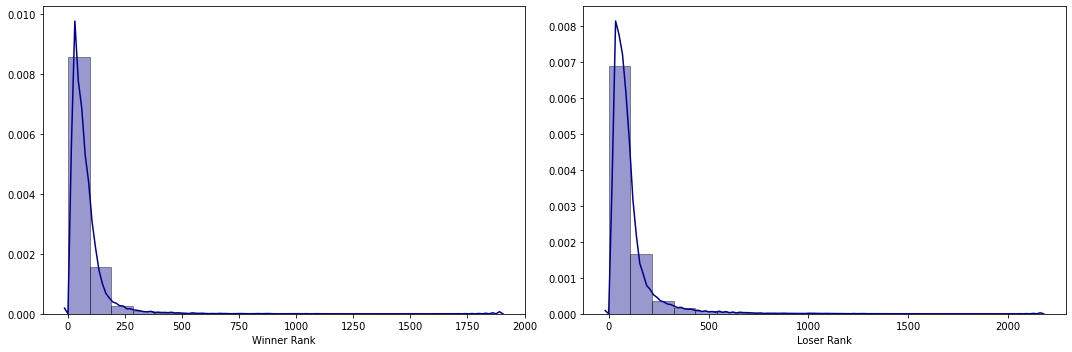

In [417]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.distplot(nonmissing_detail_stats["winner_rank"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Winner Rank")

plt.subplot(1, 2, 2)
sns.distplot(nonmissing_detail_stats["loser_rank"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Loser Rank")

plt.tight_layout()
plt.show()

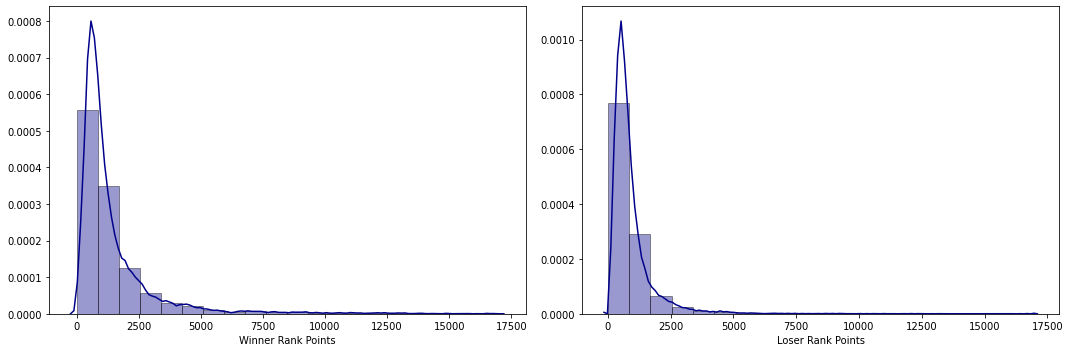

In [418]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.distplot(nonmissing_detail_stats["winner_rank_points"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Winner Rank Points")

plt.subplot(1, 2, 2)
sns.distplot(nonmissing_detail_stats["loser_rank_points"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Loser Rank Points")

plt.tight_layout()
plt.show()

We've seen a lot of interesting things and now have a much better sense of the data ATP match data. Next I'll clean the data, do some feature engineering, and then we'll dive into some analyses.  